In [1]:
import zipfile

with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset_folder')

In [3]:
# Importing libraries and evironments
import json
import os
# This command is for muting non-damaging errors - used for GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'


import numpy as np
import tensorflow as tf
# tf.config.optimizer.set_jit(False) # Disable Accelerated Linear Algebra at the beginning

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom, Rescaling, RandomContrast, RandomBrightness, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [5]:
# Loading all images 
data_dir = 'dataset_folder/PlantVillage'

image_paths = []
labels = []

# create a list of images with their respective class 
valid_file_types = {".jpg", ".jpeg", ".png"}
class_names = sorted(os.listdir(data_dir))
for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for f in os.listdir(class_dir):
        if os.path.splitext(f)[1].lower() in valid_file_types:
            image_paths.append(os.path.join(class_dir, f))
            labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

# Split into train (80%), temp (20%) for validation and test set
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=123
)

# Split temp into val/test (10% each)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=123
)

In [6]:
with open("data_splits/class_info.json", "w") as f:
    json.dump({"class_names": class_names}, f)

In [12]:
# Saving all data sets and their respective labels
os.makedirs("data_splits", exist_ok=True)

np.save("data_splits/train_paths.npy", train_paths)
np.save("data_splits/val_paths.npy", val_paths)
np.save("data_splits/test_paths.npy", test_paths)

np.save("data_splits/train_labels.npy", train_labels)
np.save("data_splits/val_labels.npy", val_labels)
np.save("data_splits/test_labels.npy", test_labels)

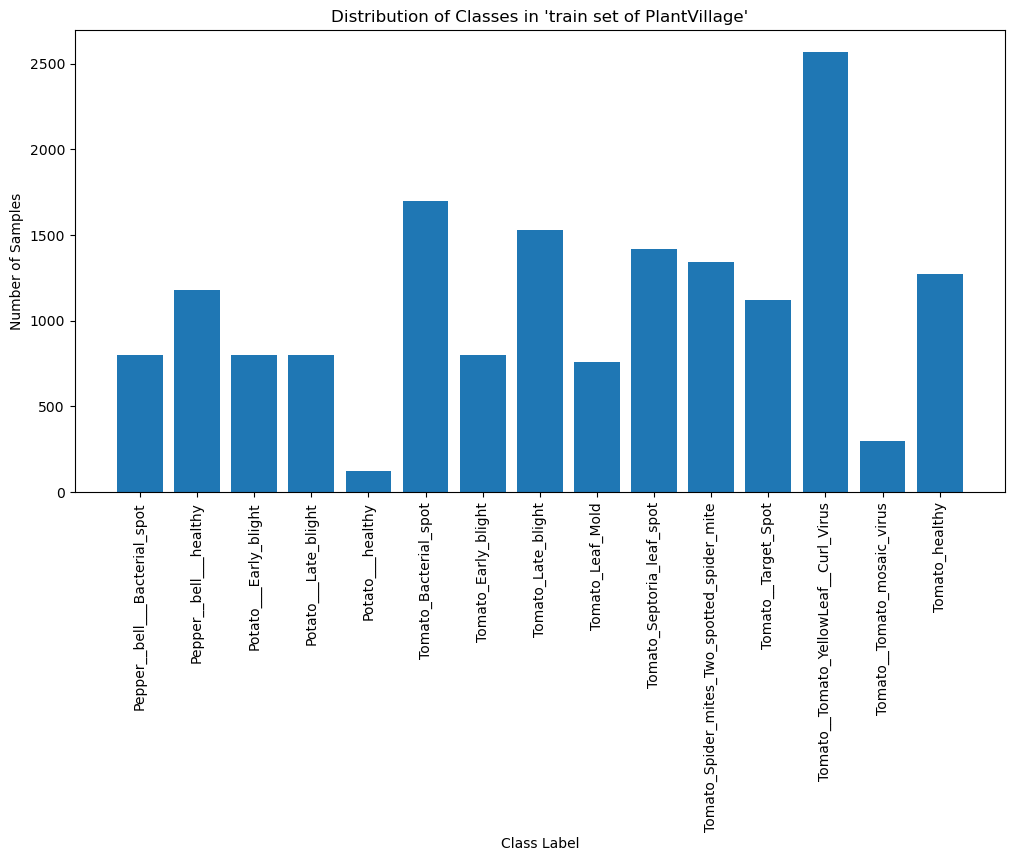

Classes of my dataset:
Pepper__bell___Bacterial_spot: 798
Pepper__bell___healthy: 1182
Potato___Early_blight: 800
Potato___Late_blight: 800
Potato___healthy: 122
Tomato_Bacterial_spot: 1701
Tomato_Early_blight: 800
Tomato_Late_blight: 1527
Tomato_Leaf_Mold: 762
Tomato_Septoria_leaf_spot: 1417
Tomato_Spider_mites_Two_spotted_spider_mite: 1341
Tomato__Target_Spot: 1123
Tomato__Tomato_YellowLeaf__Curl_Virus: 2566
Tomato__Tomato_mosaic_virus: 298
Tomato_healthy: 1273


In [4]:
# Checking how the dataset is constructed

class_counts = [np.sum(train_labels==i) for i in range(len(class_names))]

plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Distribution of Classes in 'train set of PlantVillage'")
plt.xticks(rotation=90)
plt.show()

print('Classes of my dataset:')
for name, count in zip(class_names, class_counts):
    print(f'{name}: {count}')


In [5]:
# Check if TensorFlow sees any GPU
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# List all detected GPU devices
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
Num GPUs Available: 1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Creating my three datasets

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32    # set to 32 instead of 64 for better generalization
steps_per_epoch = len(train_paths) // BATCH_SIZE


# Decode the image into a 256x256 size image with 3 (RGB) channels
def process_path(file_path, label):
    img = tf.io.read_file(file_path)                      
    img = tf.image.decode_jpeg(img, channels=3)           
    img = tf.image.resize(img, [256,256])
    return img, label

# Training set
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000).repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation set
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Test set
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

I0000 00:00:1758984565.334996     480 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5556 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [7]:
# Input layer 
inputs = Input(shape=(256,256,3))  # Height, Width, RGB

# Increase of variation in our test set
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.05),
    RandomZoom(0.05),
    RandomContrast(0.05),
    # RandomBrightness(0.2)
])

x = Rescaling(1.0/255)(inputs)    # Normalize pixel values
x = data_augmentation(x)

# Classic convolutional neural network architecture
x = Conv2D(32, (3, 3),padding='same')(x)  # only reducing our size in MaxPooling2D
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3),padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3),padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3),padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
# x = Conv2D(512, (3, 3),padding='same')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = MaxPooling2D((2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu',kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

# Create model
model = Model(inputs=inputs, outputs=outputs)

# set a scheduler for smooth convergence  
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=steps_per_epoch * 20,
    alpha=1e-5 
)

# Compile my model with optimizer, loss function and evalution metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 490,959 (1.87 MB)

 Trainable params: 489,999 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)

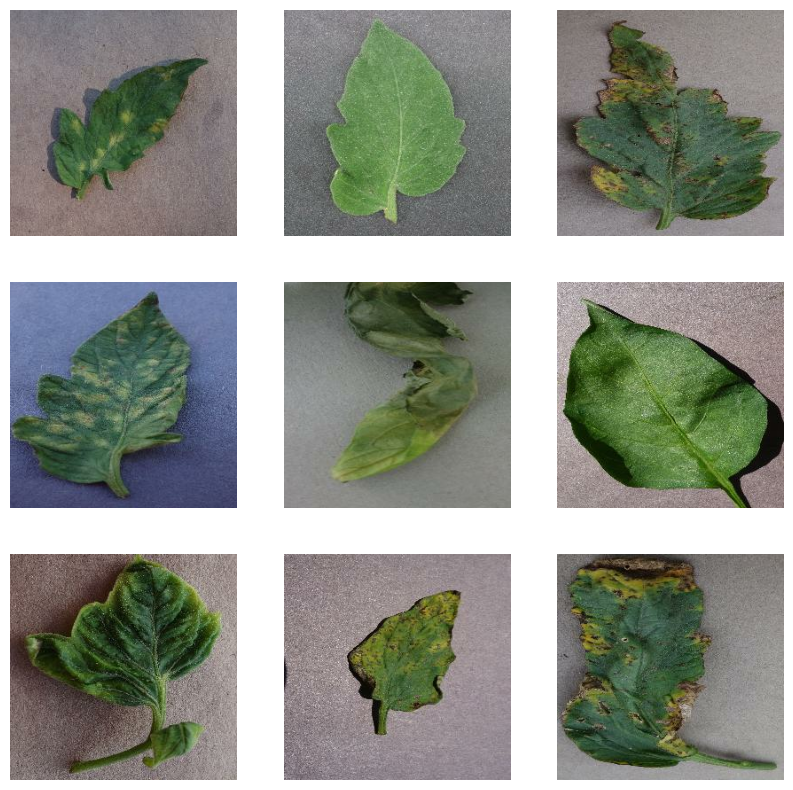

In [8]:
# Checking images for optimal parameters settings for data_augmentation

for images, _ in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
    break

In [9]:
# To give each class an equal chance of being picked 
class_weights = compute_class_weight(
    "balanced", classes=np.unique(train_labels), y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Early stopping in case of overfitting
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Training my model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/20


I0000 00:00:1758984568.660243    2009 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


515/515 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.4409 - loss: 1.7584 - val_accuracy: 0.2703 - val_loss: 3.8304
Epoch 2/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.6289 - loss: 1.1455 - val_accuracy: 0.6226 - val_loss: 1.2846
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.6956 - loss: 0.9544 - val_accuracy: 0.5446 - val_loss: 1.8120
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.7465 - loss: 0.8030 - val_accuracy: 0.5431 - val_loss: 1.7847
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.7679 - loss: 0.7347 - val_accuracy: 0.4109 - val_loss: 4.3627
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7980 - loss: 0.6597 - val_accuracy: 0.4254 - val_loss: 4.0922
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - accuracy: 0.8133 - loss: 0.5881 - val_accuracy: 0.7461 - val_loss: 0.9871
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.8335 - loss: 0.5398 - val_accurac

In [10]:
# Final evaluation on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8968 - loss: 0.4083
Test accuracy: 0.897


In [11]:
model.save("cnn_mymodel_extendedFinal2.0.keras")